In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import os
from pathlib import Path

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
### 데이터 파일을 불러옵니다 ###
import numpy as np
import pandas as pd
data = pd.read_csv('chinaHR1.csv', index_col=0)

In [3]:
df = (data - data.min()) / (data.max() - data.min())

In [4]:
### 데이터를 넘파이(numpy) 파일로 변환하고 Shape을 확인합니다 ###
HR=df.values
print(HR.shape)

(2738, 9)


In [5]:
### 2차원 데이터를 시간에 따라 스퀀스(연속)하게 투입하기 위해 3차원 넘파이로 만드는 함수입니다 ###
### 시계열 자료의 shape은 (sample, timesteps, features)의 3차원 구조를 띠어야 합니다 ###

def split_xy(dataset, time_steps, y_column):
    x, y=list(), list()
    for i in range(len(dataset)):
        x_end_number=i+time_steps
        y_end_number=x_end_number+y_column
        if y_end_number>len(dataset):
            break
        tmp_x=dataset[i:x_end_number, :]
        tmp_y=dataset[x_end_number:y_end_number, 8]
        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x), np.array(y)

In [6]:
### timesteps와 예측하려는 시점을 설정한 후, 위의 시계열 분석을 위한 3차원 데이터 자르기 함수를 적용합니다 ###
### timestep를 60, y_column을 30으로 하면 이전 60일 데이터로 향후 30일을 예측하도록 3차원 넘파이 데이터가 구성됩니다 ###
time_steps=90
y_column=30
X, Y=split_xy(HR, time_steps, y_column)
print("X.shape : ", X.shape)
print("Y.shape : ", Y.shape)

X.shape :  (2619, 90, 9)
Y.shape :  (2619, 30)


In [7]:
X_train, y_train = X[:2500, : ], Y[:2500, : ]
X_test, y_test = X[2500:, : ], Y[2500:, : ]

In [8]:
print("X_train.shape : ", X_train.shape)
print("y_train.shape : ", y_train.shape)
print("X_test.shape : ", X_test.shape)
print("y_test.shape : ", y_test.shape)

X_train.shape :  (2500, 90, 9)
y_train.shape :  (2500, 30)
X_test.shape :  (119, 90, 9)
y_test.shape :  (119, 30)


# Model1: LSTM

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 9]),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.TimeDistributed(keras.layers.Dense(y_column))
])

model_LSTM.compile(loss="mse", optimizer="adam")

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)

history = model_LSTM.fit(X_train, y_train, validation_split=0.2, verbose=1,
                     batch_size=1, epochs=50, callbacks=[early_stopping])

Epoch 1/50
2000/2000 [==============================] - 29s 14ms/step - loss: 0.0228 - val_loss: 0.0168
Epoch 2/50
2000/2000 [==============================] - 29s 14ms/step - loss: 0.0084 - val_loss: 0.0184
Epoch 3/50
2000/2000 [==============================] - 28s 14ms/step - loss: 0.0064 - val_loss: 0.0140
Epoch 4/50
2000/2000 [==============================] - 29s 14ms/step - loss: 0.0051 - val_loss: 0.0160
Epoch 5/50
2000/2000 [==============================] - 29s 14ms/step - loss: 0.0042 - val_loss: 0.0182
Epoch 6/50
2000/2000 [==============================] - 29s 14ms/step - loss: 0.0050 - val_loss: 0.0189
Epoch 7/50
2000/2000 [==============================] - 29s 14ms/step - loss: 0.0042 - val_loss: 0.0175
Epoch 8/50
2000/2000 [==============================] - 28s 14ms/step - loss: 0.0048 - val_loss: 0.0160


In [10]:
model_LSTM.evaluate(X_test)

4/4 [==============================] - 0s 544us/step - loss: 0.0000e+00


0.0

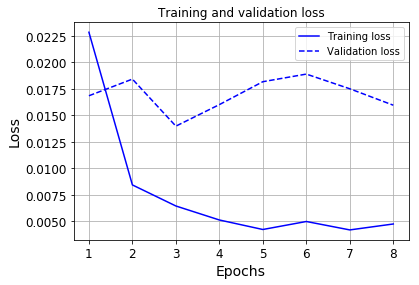

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [12]:
### 가장 마지막 시계열을 timestep만큼 가져옵니다 ###
### 예측을 위해서는 3차원 numpy이어야 하므로 차원 1을 더합니다 ###
### 학습된 모델로 예측하여 y_column만큼 예측치를 forecase에 저장합니다 ###
fore1_x=HR[-time_steps:, ]
fore1_3D=np.reshape(fore1_x, (1,time_steps,len(HR[0,:])))
forecast1 = model_LSTM.predict(fore1_3D)
fore_value1=np.reshape(forecast1[0, 0, : ], (1,y_column))

In [13]:
forecast1.shape

(1, 90, 30)

In [14]:
fore_value1

array([[0.6128582 , 0.61913985, 0.6261518 , 0.61304295, 0.6287269 ,
        0.6211065 , 0.6244671 , 0.62974906, 0.63552386, 0.6164063 ,
        0.62678033, 0.6237869 , 0.6346574 , 0.6138128 , 0.63442576,
        0.631183  , 0.6162495 , 0.6285967 , 0.63491994, 0.6555613 ,
        0.64656657, 0.64499605, 0.64631104, 0.6365496 , 0.64060366,
        0.64803207, 0.6490048 , 0.63199514, 0.6632116 , 0.65857846]],
      dtype=float32)

In [15]:
import pandas
real_scaled1=pd.DataFrame(HR[:, 8])
real_scaled1.columns=['ChinadomesticHR']
real_scaled1['group']=1

forecast_scaled1=pd.DataFrame(fore_value1[0,:])
forecast_scaled1.columns=['ChinadomesticHR']
forecast_scaled1['group']=2

Trend1=pd.concat([real_scaled1, forecast_scaled1], axis=0, ignore_index=True)
Trend1['date']=pd.date_range(start="2013-1-1", periods=len(HR)+y_column)

Trend1['orginal']=Trend1['ChinadomesticHR']*(data['ChinadomesticHR'].max()-data['ChinadomesticHR'].min())+data['ChinadomesticHR'].min()

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'price')

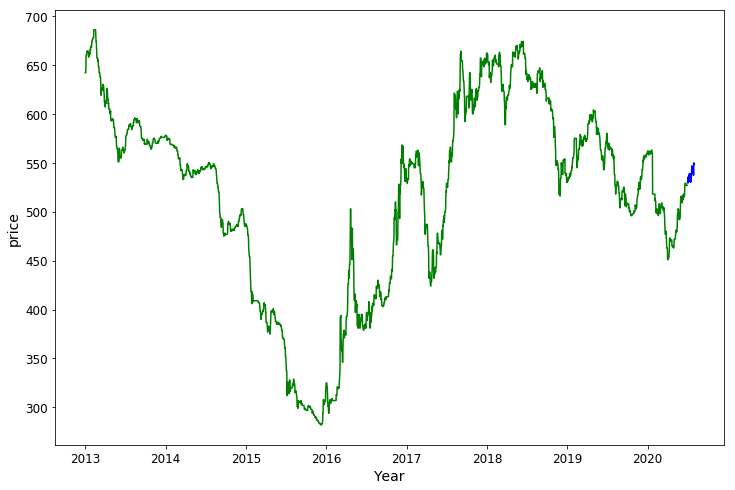

In [16]:
Real1=Trend1[(Trend1['group']==1)]
Fore1=Trend1[(Trend1['group']==2)]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(Real1['date'], Real1['orginal'], 'g-', label='Training loss')
plt.plot(Fore1['date'], Fore1['orginal'], 'b-', label='Training loss')
plt.xlabel('Year')
plt.ylabel('price')

Text(0, 0.5, 'price')

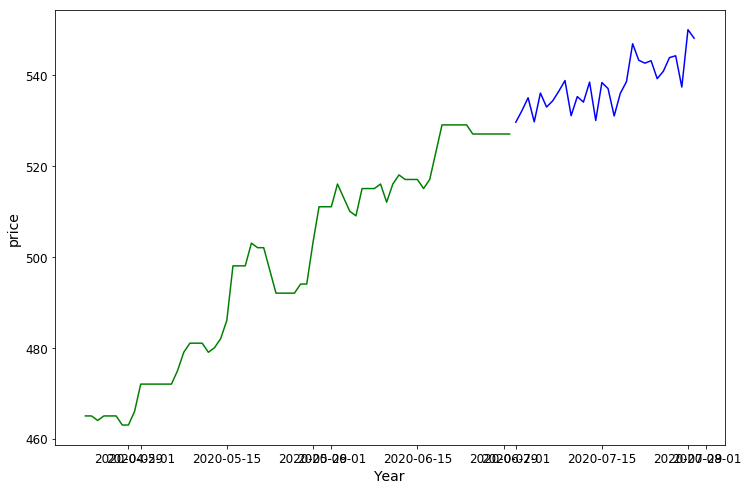

In [17]:
Trend1_100=Trend1.tail(100)

Real1_100=Trend1_100[(Trend1_100['group']==1)]
Fore1_100=Trend1_100[(Trend1_100['group']==2)]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(Real1_100['date'], Real1_100['orginal'], 'g-', label='Training loss')
plt.plot(Fore1_100['date'], Fore1_100['orginal'], 'b-', label='Training loss')
plt.xlabel('Year')
plt.ylabel('price')


# Model2: LSTM + CNN Model

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [18]:
xx=np.expand_dims(X[:, :, -1], axis=2)
y = np.expand_dims(Y, axis=2)
x = X
series=np.concatenate((xx, y), axis=1)
print("x.shape : ", x.shape)
print("y.shape : ", y.shape)
print("series.shape : ", series.shape)

x.shape :  (2619, 90, 9)
y.shape :  (2619, 30, 1)
series.shape :  (2619, 120, 1)


In [19]:
Y = np.empty((len(X), time_steps, y_column))
for step_ahead in range(1, y_column + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + time_steps, 0]
Y_train = Y[:2000]
Y_valid = Y[2000:2500]
Y_test = Y[2500:]

In [20]:
X_train, y_train = X[:2000, : ], Y[:2000, : ]
X_valid, y_valid = X[2000:2500, : ] , Y[2000:2500, : ]
X_test, y_test = X[2500:, : ], Y[2500:, : ]

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model_1DCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 9]),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.TimeDistributed(keras.layers.Dense(y_column))
])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)

model_1DCNN.compile(loss="mse", optimizer="adam")
history = model_1DCNN.fit(X_train, y_train[:, 3::2], epochs=50,
                          validation_data=(X_valid, y_valid[:, 3::2]), callbacks=[early_stopping])

Epoch 1/50
63/63 [==============================] - 1s 23ms/step - loss: 0.1236 - val_loss: 0.0247
Epoch 2/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0177 - val_loss: 0.0092
Epoch 3/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0095 - val_loss: 0.0053
Epoch 4/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 5/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 6/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 7/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 8/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 9/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 10/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 11/

In [22]:
model_1DCNN.evaluate(X_test)

4/4 [==============================] - 0s 573us/step - loss: 0.0000e+00


0.0

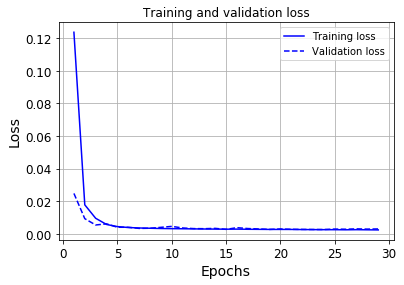

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [24]:
### 가장 마지막 시계열을 timestep만큼 가져옵니다 ###
### 예측을 위해서는 3차원 numpy이어야 하므로 차원 1을 더합니다 ###
### 학습된 모델로 예측하여 y_column만큼 예측치를 forecase에 저장합니다 ###
fore2_x=HR[-time_steps:, ]
fore2_3D=np.reshape(fore2_x, (1,time_steps,len(HR[0,:])))
forecast2 = model_1DCNN.predict(fore2_3D)
fore_value2=np.reshape(forecast2[0, 0, : ], (1,y_column))

In [25]:
forecast2

array([[[0.38612562, 0.38435778, 0.39256963, ..., 0.35942012,
         0.42007896, 0.36629403],
        [0.40946203, 0.38631406, 0.42254052, ..., 0.4094886 ,
         0.40064007, 0.41780308],
        [0.4163202 , 0.405713  , 0.4326903 , ..., 0.42786127,
         0.4217264 , 0.42774737],
        ...,
        [0.544128  , 0.54486257, 0.5918083 , ..., 0.521116  ,
         0.5242513 , 0.5246231 ],
        [0.549343  , 0.5499408 , 0.59230185, ..., 0.5282727 ,
         0.5378087 , 0.5303191 ],
        [0.54073894, 0.5405244 , 0.58867395, ..., 0.51190186,
         0.5216633 , 0.5178558 ]]], dtype=float32)

In [26]:
import pandas
real_scaled2=pd.DataFrame(HR[:, 8])
real_scaled2.columns=['ChinadomesticHR']
real_scaled2['group']=1

forecast_scaled2=pd.DataFrame(fore_value2[0,:])
forecast_scaled2.columns=['ChinadomesticHR']
forecast_scaled2['group']=2

Trend2=pd.concat([real_scaled2, forecast_scaled2], axis=0, ignore_index=True)
Trend2['date']=pd.date_range(start="2013-1-1", periods=len(HR)+y_column)

Trend2['orginal']=Trend2['ChinadomesticHR']*(data['ChinadomesticHR'].max()-data['ChinadomesticHR'].min())+data['ChinadomesticHR'].min()

Text(0, 0.5, 'price')

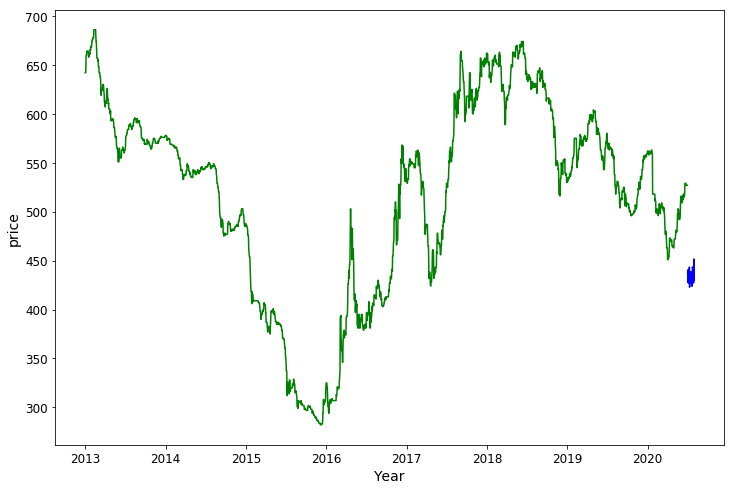

In [27]:
Real2=Trend2[(Trend2['group']==1)]
Fore2=Trend2[(Trend2['group']==2)]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(Real2['date'], Real2['orginal'], 'g-', label='Training loss')
plt.plot(Fore2['date'], Fore2['orginal'], 'b-', label='Training loss')
plt.xlabel('Year')
plt.ylabel('price')

Text(0, 0.5, 'price')

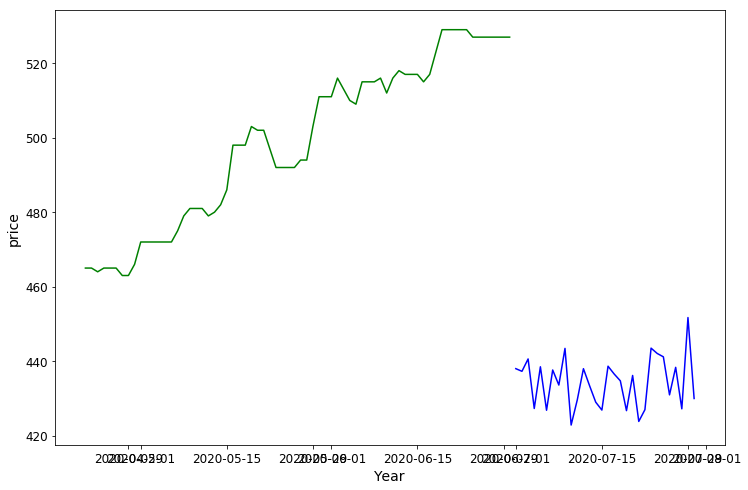

In [28]:
Trend2_100=Trend2.tail(100)

Real2_100=Trend2_100[(Trend2_100['group']==1)]
Fore2_100=Trend2_100[(Trend2_100['group']==2)]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(Real2_100['date'], Real2_100['orginal'], 'g-', label='Training loss')
plt.plot(Fore2_100['date'], Fore2_100['orginal'], 'b-', label='Training loss')
plt.xlabel('Year')
plt.ylabel('price')

In [29]:
Trend2

ChinadomesticHR  group       date     orginal
0            0.891089      1 2013-01-01  642.000000
1            0.891089      1 2013-01-02  642.000000
2            0.891089      1 2013-01-03  642.000000
3            0.908416      1 2013-01-04  649.000000
4            0.935644      1 2013-01-05  660.000000
5            0.935644      1 2013-01-06  660.000000
6            0.935644      1 2013-01-07  660.000000
7            0.945545      1 2013-01-08  664.000000
8            0.945545      1 2013-01-09  664.000000
9            0.943069      1 2013-01-10  663.000000
10           0.945545      1 2013-01-11  664.000000
11           0.945545      1 2013-01-12  664.000000
12           0.945545      1 2013-01-13  664.000000
13           0.945545      1 2013-01-14  664.000000
14           0.945545      1 2013-01-15  664.000000
15           0.930693      1 2013-01-16  658.000000
16           0.930693      1 2013-01-17  658.000000
17           0.933168      1 2013-01-18  659.000000
18           0.940594      1 2013-01-19  662.000000
19           0.940594      1 2013-01-20  662.000000
20           0.940594      1 2013-01-21  662.000000
21           0.938119      1 2013-01-22  661.000000
22           0.943069      1 2013-01-23  663.000000
23           0.950495      1 2013-01-24  666.000000
24           0.948020      1 2013-01-25  665.000000
25           0.957921      1 2013-01-26  669.000000
26           0.957921      1 2013-01-27  669.000000
27           0.957921      1 2013-01-28  669.000000
28           0.955446      1 2013-01-29  668.000000
29           0.960396      1 2013-01-30  670.000000
...               ...    ...        ...         ...
2738         0.386126      2 2020-07-01  437.994752
2739         0.384358      2 2020-07-02  437.280543
2740         0.392570      2 2020-07-03  440.598131
2741         0.359656      2 2020-07-04  427.300990
2742         0.387365      2 2020-07-05  438.495477
2743         0.358480      2 2020-07-06  426.825947
2744         0.385235      2 2020-07-07  437.634848
2745         0.375228      2 2020-07-08  433.592179
2746         0.399585      2 2020-07-09  443.432524
2747         0.348655      2 2020-07-10  422.856458
2748         0.365392      2 2020-07-11  429.618175
2749         0.386099      2 2020-07-12  437.983940
2750         0.374759      2 2020-07-13  433.402655
2751         0.363839      2 2020-07-14  428.990944
2752         0.358601      2 2020-07-15  426.874745
2753         0.387754      2 2020-07-16  438.652517
2754         0.382556      2 2020-07-17  436.552669
2755         0.378034      2 2020-07-18  434.725650
2756         0.358218      2 2020-07-19  426.719885
2757         0.381592      2 2020-07-20  436.163339
2758         0.351047      2 2020-07-21  423.822787
2759         0.358862      2 2020-07-22  426.980361
2760         0.399749      2 2020-07-23  443.498612
2761         0.396214      2 2020-07-24  442.070423
2762         0.393979      2 2020-07-25  441.167425
2763         0.368713      2 2020-07-26  430.960145
2764         0.386993      2 2020-07-27  438.345253
2765         0.359420      2 2020-07-28  427.205729
2766         0.420079      2 2020-07-29  451.711901
2767         0.366294      2 2020-07-30  429.982787

[2768 rows x 4 columns]

# Model3: WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model_WaveNet = tf.keras.models.Sequential()
model_WaveNet.add(tf.keras.layers.InputLayer(input_shape=[None, 9]))
for rate in (1, 2, 4, 8, 16, 32, 64) * 2:
    model_WaveNet.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model_WaveNet.add(tf.keras.layers.Conv1D(filters=y_column, kernel_size=1))
model_WaveNet.compile(loss="mse", optimizer="adam")

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)

history = model_WaveNet.fit(X_train, y_train, validation_split=0.2, verbose=1,
                     batch_size=1, epochs=50, callbacks=[early_stopping])

Epoch 1/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0157 - val_loss: 0.0353
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0036 - val_loss: 0.0296
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0028 - val_loss: 0.0234
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0023 - val_loss: 0.0216
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0019 - val_loss: 0.0182
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0019 - val_loss: 0.0244
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0022 - val_loss: 0.0172
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0016 - val_loss: 0.0430
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0017 - val_loss: 0.0311
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/step - loss: 0.001

In [31]:
model_WaveNet.evaluate(X_test)

4/4 [==============================] - 0s 543us/step - loss: 0.0000e+00


0.0

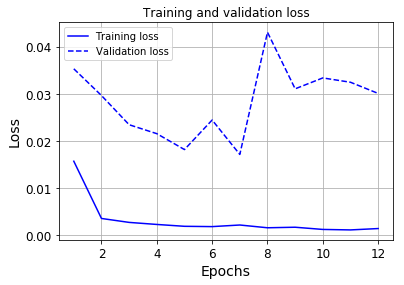

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [33]:
### 가장 마지막 시계열을 timestep만큼 가져옵니다 ###
### 예측을 위해서는 3차원 numpy이어야 하므로 차원 1을 더합니다 ###
### 학습된 모델로 예측하여 y_column만큼 예측치를 forecase에 저장합니다 ###
fore3_x=HR[-time_steps:, ]
fore3_3D=np.reshape(fore3_x, (1,time_steps,len(HR[0,:])))
forecast3 = model_WaveNet.predict(fore3_3D)
fore_value3=np.reshape(forecast3[0, 0, : ], (1,y_column))

In [34]:
fore_value3

array([[0.45267314, 0.44781044, 0.44535217, 0.4476893 , 0.44809264,
        0.44851148, 0.44647217, 0.44419348, 0.44662803, 0.44606045,
        0.44388294, 0.44421786, 0.44351315, 0.44109678, 0.4429463 ,
        0.43967688, 0.44033235, 0.4369068 , 0.43902057, 0.44170302,
        0.4385628 , 0.43949807, 0.44137108, 0.43954915, 0.43936244,
        0.43637836, 0.440899  , 0.4394626 , 0.43928808, 0.44135642]],
      dtype=float32)

In [35]:
forecast3

array([[[0.45267314, 0.44781044, 0.44535217, ..., 0.4394626 ,
         0.43928808, 0.44135642],
        [0.4415766 , 0.43743995, 0.43488726, ..., 0.43191278,
         0.4313517 , 0.4335379 ],
        [0.44184124, 0.43763846, 0.43510342, ..., 0.43213403,
         0.43170446, 0.43379712],
        ...,
        [0.53715706, 0.53257835, 0.53523946, ..., 0.57021534,
         0.5709507 , 0.57522935],
        [0.54121184, 0.5385528 , 0.54150146, ..., 0.5783767 ,
         0.57914567, 0.5817688 ],
        [0.5437922 , 0.5366746 , 0.5427984 , ..., 0.576225  ,
         0.57546806, 0.57757837]]], dtype=float32)

In [36]:
import pandas
real_scaled3=pd.DataFrame(HR[:, 8])
real_scaled3.columns=['ChinadomesticHR']
real_scaled3['group']=1

forecast_scaled3=pd.DataFrame(fore_value3[0,:])
forecast_scaled3.columns=['ChinadomesticHR']
forecast_scaled3['group']=2

Trend3=pd.concat([real_scaled3, forecast_scaled3], axis=0, ignore_index=True)
Trend3['date']=pd.date_range(start="2013-1-1", periods=len(HR)+y_column)

Trend3['orginal']=Trend3['ChinadomesticHR']*(data['ChinadomesticHR'].max()-data['ChinadomesticHR'].min())+data['ChinadomesticHR'].min()

Text(0, 0.5, 'price')

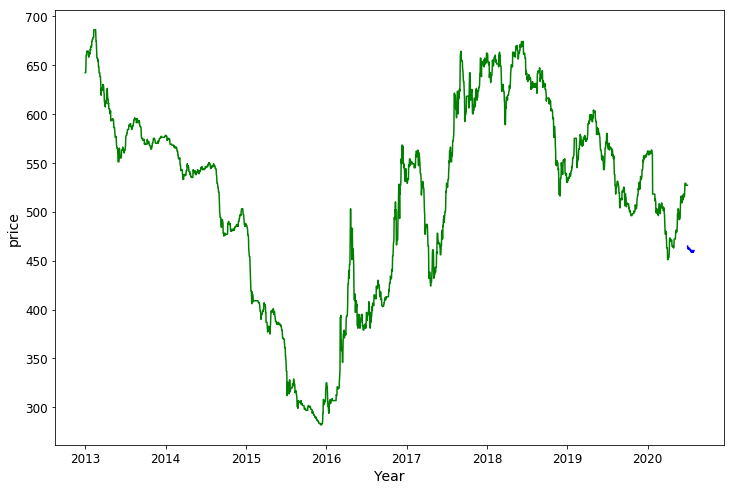

In [37]:
Real3=Trend3[(Trend3['group']==1)]
Fore3=Trend3[(Trend3['group']==2)]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(Real3['date'], Real3['orginal'], 'g-', label='Training loss')
plt.plot(Fore3['date'], Fore3['orginal'], 'b-', label='Training loss')
plt.xlabel('Year')
plt.ylabel('price')

Text(0, 0.5, 'price')

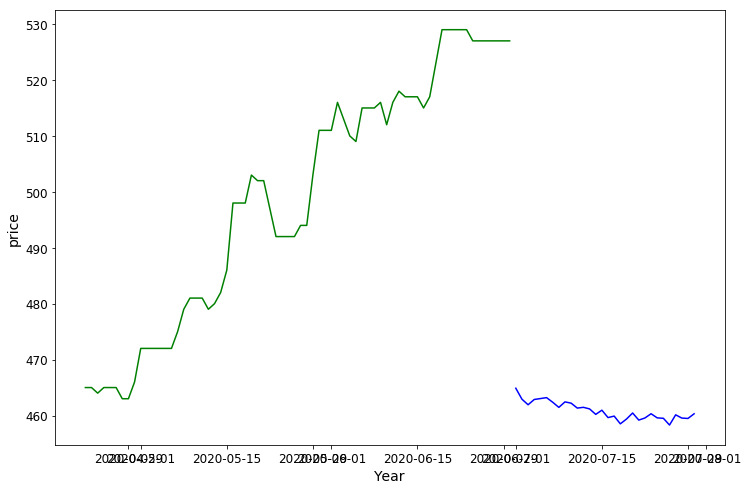

In [38]:
Trend3_100=Trend3.tail(100)

Real3_100=Trend3_100[(Trend3_100['group']==1)]
Fore3_100=Trend3_100[(Trend3_100['group']==2)]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(Real3_100['date'], Real3_100['orginal'], 'g-', label='Training loss')
plt.plot(Fore3_100['date'], Fore3_100['orginal'], 'b-', label='Training loss')
plt.xlabel('Year')
plt.ylabel('price')

In [ ]:
Trend3